# COMP9418 Assignment 2

## *Tasks TODO*
- parameter initialization
- mean negative log probability
- sample predictions.txt generator


In [370]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import hmmlearn
import sklearn
from hmmlearn.hmm import GaussianHMM, GMMHMM
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [371]:
# make sure it's version 0.2.1 (install from github, not pip)
# pip install git+https://github.com/hmmlearn/hmmlearn.git
hmmlearn.__version__

'0.2.1'

In [372]:
sklearn.__version__

'0.19.0'

In [373]:
seed = 1234
rng = np.random.RandomState(seed)

In [374]:
# Load the data
trainData = sio.loadmat('./trajectories_train.mat')
testData = sio.loadmat('./trajectories_xtest.mat')

In [375]:
# Clean up the data
xtrain = trainData['xtrain'].reshape((-1, ))
ytrain = trainData['ytrain'].reshape((-1, ))
kf = StratifiedKFold(n_splits = 3, random_state=rng)
xtest = testData['xtest'].reshape((-1, ))
key = trainData['key']
key = [item[0] for item in key.reshape((-1, ))]

In [376]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
# print([sum(yval == i) for i in np.unique(ytrain)])

(1429,)
(1429,)
(1429,)


# Data visualization

In [377]:
idx = 50

In [378]:
x = xtrain[idx]
y = ytrain[idx]

In [379]:
def plot_char(data, label):
    start_x = 0
    start_y = 0
    plt.plot(start_x, start_y, 'ro')
    for vel_h, vel_v, alpha in zip(data[0,], data[1, ], 1/(1 + np.exp(-data[2, ]/np.sum(data[1, ])))):
        start_x = start_x + vel_h
        start_y = start_y + vel_v
        plt.plot(start_x, start_y,'bo', alpha = alpha)
    plt.title('Character ' + key[label-1])
    plt.show()

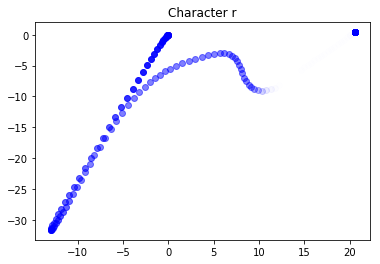

In [380]:
plot_char(x, y)

# Data Cleaning and Preparation

In [381]:
xtrain = np.asarray([seq.T for seq in xtrain])
xtest = np.asarray([seq.T for seq in xtest])

In [382]:
train_max = np.max(np.vstack(xtrain), axis=0)
train_min = np.min(np.vstack(xtrain), axis=0)
def rescale(seq):
    return (seq - train_min) / (train_max - train_min)

In [383]:
xtrain = np.asarray([rescale(seq) for seq in xtrain])
xtest = np.asarray([rescale(seq) for seq in xtest])

In [384]:
print(xtrain.shape)
print(xtest.shape)

(1429,)
(1429,)


In [385]:
lengths_train = list(map(lambda x: x.shape[0], xtrain))
lengths_test = list(map(lambda x: x.shape[0], xtest))

In [386]:
label_enc = LabelEncoder().fit(ytrain)
label_enc.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=uint8)

# Generative Classifier

In [387]:
def log_likelihood(hmm, sequence):

    logprob_frame = hmm._compute_log_likelihood(sequence)
    logprob_sequence, _ =  hmm._do_forward_pass(logprob_frame)

    return logprob_sequence

def log_likelihoods(hmm, sequences):

    ll = lambda seq: log_likelihood(hmm, seq)

    return np.fromiter(map(ll, sequences), dtype='float64')

def log_likelihoods_cond(cond_hmms, sequences):

    ll = lambda hmm: log_likelihoods(hmm, sequences)

    return np.vstack(map(ll, cond_hmms))

In [388]:
# Original Class we had that could only take in 1 n_state for all the HMMs

# class GenerativeClassifierHMM(BaseEstimator, ClassifierMixin):

#     def __init__(self, hmm=GaussianHMM()):

#         self.hmm = hmm
#         self.class_cond_hmms_ = []

#     def fit(self, sequences, labels):

#         class_counts = np.bincount(labels).astype(np.float)
#         self.logprior = np.log(class_counts / np.sum(class_counts))

#         for c in range(np.max(labels)+1):

#             sequences_c = sequences[labels == c]

#             X_c = np.vstack(sequences_c)
#             lengths_c = list(map(len, sequences_c))
            
#             class_cond_hmm = clone(self.hmm, safe=True)
#             class_cond_hmm.fit(X_c, lengths=lengths_c)

#             self.class_cond_hmms_.append(class_cond_hmm)

#         return self
    
#     def predict(self, sequences):
#         # 20 x N matrix
#         log_likelihood_ = log_likelihoods_cond(self.class_cond_hmms_, sequences)

#         log_post_unnorm = log_likelihood_ + self.logprior.reshape(-1, 1)

#         return np.argmax(log_post_unnorm, axis=0)
    
#     def generateSample(self, mClass, length):
#         sel_hmm = self.class_cond_hmms_[mClass]
#         x, _ = sel_hmm.sample(length)
#         return x

In [389]:
# Make sure to keep the init_params commented otherwise it doesn't work properly for some reason

class GenerativeClassifierHMM(BaseEstimator, ClassifierMixin):
    def __init__(self, hmm=GaussianHMM()):
        self.hmm = hmm
        self.class_cond_hmms_ = []

    def fit(self, sequences, labels, k):        
        class_counts = np.bincount(labels).astype(np.float)
        self.logprior = np.log(class_counts / np.sum(class_counts))
        
        for c in range(np.max(labels)+1):
            sequences_c = sequences[labels == c]
            X_c = np.vstack(sequences_c)
            lengths_c = list(map(len, sequences_c))
            class_cond_hmm = clone(self.hmm, safe=True)
            n_states_k = k[c]
            pi0 = np.eye(1, n_states_k)[0]
            trans0 = np.diag(np.ones(n_states_k)) + np.diag(np.ones(n_states_k-1), 1)
            trans0 /= trans0.sum(axis=1).reshape(-1, 1)
            class_cond_hmm.n_components = n_states_k
            class_cond_hmm.startprob_ = pi0
            class_cond_hmm.transmat_  = trans0
            class_cond_hmm.fit(X_c, lengths=lengths_c)
            self.class_cond_hmms_.append(class_cond_hmm)

        return self
    
    def predict(self, sequences):
        # 20 x N matrix
        log_likelihood_ = log_likelihoods_cond(self.class_cond_hmms_, sequences)

        log_post_unnorm = log_likelihood_ + self.logprior.reshape(-1, 1)

        return np.argmax(log_post_unnorm, axis=0)
    
    def generateSample(self, mClass, length):
        sel_hmm = self.class_cond_hmms_[mClass]
        x, _ = sel_hmm.sample(length)
        return x

# Guassian HMM

In [390]:
# # Parameters
# n_states = 10

# # initial guess for EM
# pi0 = np.eye(1, n_states)[0] # start probability
# pi0

# # initial guess for EM
# # transition matrix
# trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
# trans0 /= trans0.sum(axis=1).reshape(-1, 1)
# trans0

In [391]:
hmm = GaussianHMM(n_components=n_states, 
#                   init_params='mc',
                  n_iter=10,
                  random_state=seed)
# hmm.startprob_ = pi0
# hmm.transmat_  = trans0

In [392]:
# due to https://github.com/hmmlearn/hmmlearn/issues/158 and 
# https://github.com/hmmlearn/hmmlearn/issues/175
# the fitting process is going to give a LOT of warnings
# so we hide them in this notebook
import warnings
warnings.filterwarnings('ignore')

In [393]:
hmm_classifier = GenerativeClassifierHMM(hmm)

train_index, test_index = list(kf.split(xtrain, ytrain))[0]

hmm_classifier.fit(xtrain[train_index], 
                   label_enc.transform(ytrain[train_index]),
                   np.tile(10, 20))

GenerativeClassifierHMM(hmm=GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=10, n_iter=10, params='stmc',
      random_state=1234, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False))

In [394]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[test_index]))

In [395]:
print('Validation Accuracy', (y_val_pred == ytrain[test_index]).mean())

('Validation Accuracy', 0.91286307053941906)


In [396]:
y_train_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[train_index]))

In [397]:
print('Training Accuracy', (y_train_pred == ytrain[train_index]).mean())

('Training Accuracy', 0.92291446673706445)


## Confusion Matrix

In [398]:
import pandas
conf_mat = pandas.DataFrame(confusion_matrix(ytrain[test_index], y_val_pred))
conf_mat.columns = key
conf_mat.index = key
conf_mat

,a,b,c,d,e,g,h,l,m,n,o,p,q,r,s,u,v,w,y,z
a,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
b,0,26,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
c,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
g,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0
h,0,0,0,0,0,0,8,0,1,5,0,0,0,0,0,0,0,5,0,0
l,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0
m,0,0,0,0,0,0,0,0,17,2,0,0,0,0,0,0,0,4,0,0
n,0,0,0,0,0,0,0,0,5,14,0,0,0,0,0,0,0,2,0,0


In [399]:
import pandas
conf_mat = pandas.DataFrame(confusion_matrix(ytrain[train_index], y_train_pred))
conf_mat.columns = key
conf_mat.index = key
conf_mat

,a,b,c,d,e,g,h,l,m,n,o,p,q,r,s,u,v,w,y,z
a,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
b,0,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
c,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
g,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
h,0,0,0,0,0,0,22,0,1,7,0,0,0,1,0,0,0,7,0,0
l,0,0,0,0,0,0,0,49,0,1,0,0,0,1,0,0,0,1,0,0
m,0,0,0,0,0,0,0,0,29,8,0,0,0,0,0,0,0,7,0,0
n,0,0,0,0,0,0,1,0,10,27,0,0,0,0,0,0,0,3,0,0


### Observations of validations confusion matrix
* h gets mixed up with n, w
* m gets mixed up with m, u, w
* n gets mixed up with m, w
* u gets mixed up with w

### Observations of training confusion matrix
* h gets mixed up with n, w
* m gets mixed up with u, w
* n gets mixed up with n, w, m
* p gets mixed up with n
* u gets mixed up with a, w
* w gets mixed up with a, n

Generate a random sample from the gmm for a certain class

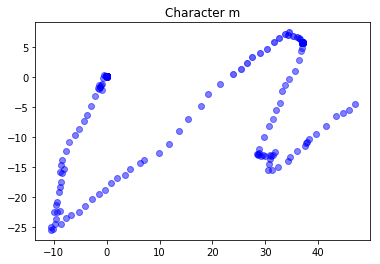

In [400]:
myClass = [9]
# ? Mattia, you had the following line but didn't run on mine until I added the [0]. Can you confirm?
# x = hmm_classifier.generateSample(label_enc.transform(myClass), 200)
x = hmm_classifier.generateSample(label_enc.transform(myClass)[0], 200)
x = x * (train_max - train_min) + train_min
plot_char(x.T, myClass[0])

### Basic Cross Validation

In [212]:
cv1_results = {}
for k in range(5, 31):
    pi0 = np.eye(1, k)[0]
    trans0 = np.diag(np.ones(k)) + np.diag(np.ones(k-1), 1)
    trans0 /= trans0.sum(axis=1).reshape(-1, 1)
    hmm = GaussianHMM(n_components=k, 
                      init_params='mc',
                      n_iter=10,
                      random_state=seed)
    correct = 0.0
    for train_index, test_index in kf.split(xtrain, ytrain):
        hmm.startprob_ = pi0
        hmm.transmat_  = trans0
        hmm_classifier = GenerativeClassifierHMM(hmm)

        hmm_classifier.fit(xtrain[train_index], label_enc.transform(ytrain[train_index]))
        y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[test_index]))
        correct += np.sum(y_val_pred == ytrain[test_index])
    accuracy = correct/xtrain.shape[0]
    cv1_results[k] = accuracy
    print('Accuracy', k, accuracy)

In [ ]:
cv2_results = {}
for k in range(5, 31):
    pi0 = np.eye(1, k)[0]
    trans0 = np.diag(np.ones(k)) + np.diag(np.ones(k-1), 1)
    trans0 /= trans0.sum(axis=1).reshape(-1, 1)
    hmm = GaussianHMM(n_components=k, 
                      init_params='mc',
                      n_iter=10,
                      random_state=seed)
    class_cond_accuracies = {}
    for train_index, test_index in kf.split(xtrain, ytrain):
        hmm.startprob_ = pi0
        hmm.transmat_  = trans0
        hmm_classifier = GenerativeClassifierHMM(hmm)

        hmm_classifier.fit(xtrain[train_index], label_enc.transform(ytrain[train_index]))
        for label in label_enc.classes_:
            class_cond_xtest = xtrain[test_index][ytrain[test_index] == label]
            y_class_cond_pred = label_enc.inverse_transform(hmm_classifier.predict(class_cond_xtest))
            class_cond_accuracy = (y_class_cond_pred == label).mean()
            if (not class_cond_accuracies.has_key(label)):
                class_cond_accuracies[label] = []
            class_cond_accuracies[label] = class_cond_accuracies[label] + [class_cond_accuracy]

    k_states_results = {}
    for label in label_enc.classes_:
        k_states_results[label] = np.mean(class_cond_accuracies[label])
    cv2_results[k] = k_states_results
    print('Average for k = ', k, np.mean(cv2_results[k].values()))

('Average for k = ', 5, 0.73516404310209515)
('Average for k = ', 6, 0.77170053423319063)
('Average for k = ', 7, 0.82463536372694468)
('Average for k = ', 8, 0.85141150450003433)
('Average for k = ', 9, 0.87754455065691717)
('Average for k = ', 10, 0.88568322248456699)
('Average for k = ', 11, 0.88951240595047787)
('Average for k = ', 12, 0.88555516362080999)
('Average for k = ', 13, 0.88400382273213118)
('Average for k = ', 14, 0.89725385648655087)
('Average for k = ', 15, 0.89924318450181351)
('Average for k = ', 16, 0.90491572420467359)
('Average for k = ', 17, 0.8954297766409226)
('Average for k = ', 18, 0.89871134555368926)
('Average for k = ', 19, 0.90568653234390273)
('Average for k = ', 20, 0.90366541188456717)
('Average for k = ', 21, 0.90985052144686962)
('Average for k = ', 22, 0.90888175845293495)
('Average for k = ', 23, 0.90647960238373082)
('Average for k = ', 24, 0.89597965709354921)
('Average for k = ', 25, 0.90346232076995803)


In [211]:
result = pandas.DataFrame(cv2_results).T
result.columns = key
result.round(4)

,a,b,c,d,e,g,h,l,m,n,o,p,q,r,s,u,v,w,y,z
5,0.9757,0.9405,0.8939,0.0000,0.9792,0.88,0.1930,0.8224,0.5507,0.3238,0.9545,0.9143,0.8070,0.6877,1.0000,0.0476,1.0000,0.7588,0.9848,0.9892
6,1.0000,0.9167,0.9394,0.0139,0.9896,1.00,0.4211,0.8481,0.4901,0.4056,0.9545,0.9281,0.8947,0.6886,0.9841,0.4697,1.0000,0.5333,0.9565,1.0000
7,0.9757,0.8929,0.9545,1.0000,0.9896,1.00,0.2982,0.7721,0.5942,0.4865,0.9697,0.9281,0.9474,0.8263,0.9690,0.2994,1.0000,0.6035,0.9855,1.0000
8,0.9877,0.9167,0.9394,1.0000,0.9896,1.00,0.2807,0.8471,0.5817,0.5651,0.9697,0.9426,0.9298,0.8096,1.0000,0.5628,1.0000,0.8079,0.8979,1.0000
9,0.9877,0.9524,0.9697,1.0000,0.9896,1.00,0.4912,0.8851,0.5975,0.5151,0.9848,0.9287,0.9123,0.8096,0.9848,0.7511,1.0000,0.7912,1.0000,1.0000
10,0.9881,0.9643,0.9848,1.0000,0.9896,1.00,0.4737,0.8476,0.6719,0.5167,0.9848,0.9571,0.9474,0.8439,1.0000,0.7807,1.0000,0.7921,0.9710,1.0000
11,0.9877,0.9286,1.0000,1.0000,0.9896,1.00,0.3333,0.8599,0.6561,0.5968,0.9848,0.9710,0.9474,0.8614,0.9848,0.8427,1.0000,0.8605,0.9855,1.0000
12,0.9877,0.9405,0.9545,1.0000,0.9896,1.00,0.3509,0.8485,0.6700,0.5325,0.9848,0.9149,0.9649,0.8956,0.9848,0.8283,1.0000,0.8781,0.9855,1.0000
13,0.9881,0.9405,0.9848,1.0000,0.9896,1.00,0.3158,0.8737,0.6403,0.6286,0.9848,0.9432,0.9474,0.8956,0.9690,0.7330,1.0000,0.8456,1.0000,1.0000
14,0.9877,0.9524,0.9697,1.0000,0.9896,1.00,0.4211,0.8613,0.6555,0.6786,0.9848,0.9571,0.9474,0.9474,0.9690,0.8593,0.9889,0.7754,1.0000,1.0000


In [320]:
# Highest n_states for each character
np.asarray(range(5, 31))[np.argmax(np.asarray(result), axis=0)]

array([ 6, 10, 11,  7,  6,  6, 16, 30, 17, 14, 15, 21, 25, 17,  5, 17,  5,
       30,  9,  6])

In [321]:
# Handpicked highest
# [15, 10, 11, 10, 10, 10, 16, 30, 17, 14, 15, 21, 25, 17, 10, 17, 10, 30, 15, 15]

## Retraining the classifier using the "Optimized" number of states

In [328]:
hmm_classifier = GenerativeClassifierHMM(hmm)

train_index, test_index = list(kf.split(xtrain, ytrain))[0]

hmm_classifier.fit(xtrain[train_index], 
                   label_enc.transform(ytrain[train_index]),
                   np.array([15, 10, 11, 10, 10, 10, 16, 30, 17, 14, 15, 21, 25, 17, 10, 17, 10, 30, 15, 15]))


GenerativeClassifierHMM(hmm=GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=10, n_iter=10, params='stmc',
      random_state=1234, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False))

In [329]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[test_index]))

In [330]:
print('Validation Accuracy', (y_val_pred == ytrain[test_index]).mean())

('Validation Accuracy', 0.82572614107883813)


In [331]:
y_train_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[train_index]))

In [332]:
print('Training Accuracy', (y_train_pred == ytrain[train_index]).mean())

('Training Accuracy', 0.86166842661034848)


# Gaussian HMM with different states per class

In [106]:
class GenerativeClassifierHMMCV(BaseEstimator, ClassifierMixin):

    def __init__(self, k=range(3,9)):
        self.class_cond_hmms_ = []
        self.k = k

    def fit(self, sequences, labels):
        kf = KFold(n_splits = 3)
        class_counts = np.bincount(labels).astype(np.float)
        self.logprior = np.log(class_counts / np.sum(class_counts))

        for c in range(np.max(labels)+1):
            sequences_c = sequences[labels == c]
            sequences_not_c = sequences[labels != c]

            lengths_c = np.array(list(map(len, sequences_c)))
            log_likels = {}
            for n_states in self.k: 
                pi0 = np.eye(1, n_states)[0] # start probability

                trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
                trans0 /= trans0.sum(axis=1).reshape(-1, 1)
                
                hmm = GaussianHMM(n_components=n_states, 
                  init_params='mc',
                  n_iter=10,
                  random_state=seed)
                
                log_likel = 0
                for train_index, test_index in kf.split(sequences_c):
                    hmm.startprob_ = pi0
                    hmm.transmat_  = trans0
                    
                    X_c = np.vstack(sequences_c[train_index])
                    
                    hmm.fit(X_c, lengths=lengths_c[train_index])
                    log_likel += np.sum(log_likelihoods(hmm, sequences_c[test_index]))
                    
                log_likels[n_states] = log_likel
                print('Label ' + str(c) + ' for states ' + str(n_states) + ': Log in class ' + 
                      str(log_likel) + 
                      '\nmax log off class ' + str(np.max(log_likelihoods(hmm, sequences_not_c)))
                     + '\n min log in class ' + str(np.min(log_likelihoods(hmm, sequences_c))))
                
#             self.class_cond_hmms_.append(class_cond_hmm)

        return self
    
    def predict(self, sequences):
        # 20 x N matrix
        log_likelihood_ = log_likelihoods_cond(self.class_cond_hmms_, sequences)

        log_post_unnorm = log_likelihood_ + self.logprior.reshape(-1, 1)

        return np.argmax(log_post_unnorm, axis=0)

In [ ]:
hmm_classifier_CV = GenerativeClassifierHMMCV(k = range(15, 31))
hmm_classifier_CV.fit(xtrain, 
                   label_enc.transform(ytrain))

# Gaussian Mixture HMM

**Note**:
I was getting some results (70%) with these parameters when I was on version 0.2.0 but after updating to the latest
version (0.2.1), GMMHMM hasn't been great and it's taking too long to run. There are some open issues on their Github which seem to suggest GMMHMM is a bit buggy atm.

In [97]:
# Parameters
n_states = 3
n_mix = 10
# initial guess for EM
pi0 = np.eye(1, n_states)[0] # start probability
pi0

# initial guess for EM
# transition matrix
trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
trans0 /= trans0.sum(axis=1).reshape(-1, 1)
trans0

array([[ 0.5,  0.5,  0. ],
       [ 0. ,  0.5,  0.5],
       [ 0. ,  0. ,  1. ]])

In [102]:
gmmhmm = GMMHMM(n_components=n_states, 
                n_mix=n_mix,
                covariance_type='diag',
                init_params='mc',
                n_iter=3,
                random_state=rng)
gmmhmm.startprob_ = pi0
gmmhmm.transmat_  = trans0

In [103]:
hmm_classifier = GenerativeClassifierHMM(gmmhmm)
hmm_classifier.fit(xtrain, label_enc.transform(ytrain))

GenerativeClassifierHMM(hmm=GMMHMM(algorithm='viterbi', covariance_type='diag', covars_prior=None,
    covars_weight=None, init_params='mc', means_prior=0.0,
    means_weight=0.0, min_covar=0.001, n_components=3, n_iter=3, n_mix=10,
    params='stmcw',
    random_state=<mtrand.RandomState object at 0x000000000A48A3A8>,
    startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False,
    weights_prior=1.0))

In [104]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xval))

(20L, 429L)
(20L,)


In [105]:
print('Accuracy', (y_val_pred == yval).mean())

('Accuracy', 0.38694638694638694)
